
# VGG16 pretrained model 

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd


In [2]:
import theano

Using gpu device 0: GRID K520 (CNMeM is enabled)


In [3]:
from keras import backend as K
K.image_dim_ordering()

Using Theano backend.


'tf'

In [4]:
import keras
keras.__version__
#needs at least 1.0.6 to run pre-trained models

'1.1.0'

In [5]:
K.set_image_dim_ordering('th')
K.image_dim_ordering()

'th'

In [6]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation,GlobalAveragePooling2D,ZeroPadding2D
from keras.optimizers import RMSprop, SGD, Adam, adadelta
from keras.layers.advanced_activations import PReLU
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [7]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

ROWS =112
COLS = 112
CHANNELS = 3

#train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset, try using as many images as memory allows
train_images = train_dogs[-20:] + train_cats[-20:]
val_images=train_dogs[-5:]+train_cats[-5:]

random.shuffle(train_images)
random.shuffle(val_images)


def read_image(file_path):
    
    img=cv2.resize(cv2.imread(file_path), (ROWS, COLS), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    img=img.transpose((2,0,1)) #use this if you want the image to be (channel, row, cols)
    return img

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS ))

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        #if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data



In [8]:
#note, the names of the test files don't come sorted numerically! split the names and map the number to integer
index=[]
for i in os.listdir(TEST_DIR):

    num,fil=i.split('.')
    index.append(num)
ID = list(map(int, index))

In [9]:
train = prep_data(train_images)
test = prep_data(test_images)
val=prep_data(val_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (40, 3, 112, 112)
Test shape: (12500, 3, 112, 112)


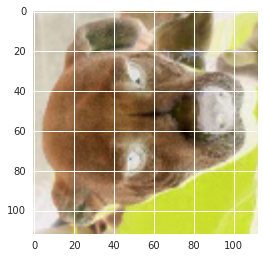

In [10]:
#shows a sample picture 
plt.imshow(train[12].T)

In [11]:
img_width, img_height = 112,112 # lack of memmory to prevent running with size 224x224

train_data_dir = 'train2'
validation_data_dir = 'validation'

nb_train_samples = 22000
nb_validation_samples = 3000
nb_epoch = 10

In [12]:
import h5py

In [39]:
def VGG_16():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3,img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    

    weights_path='vgg16_weights_original.h5'
    #courtesy of xyz on kaggle, this adjust the index for the weights to be loaded into the model, because
    #input image size is not 224
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):break
    # we don't look at the last (fully-connected) layers in the savefile
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights) #sets the selected weight from pre-trained weight
    f.close()
    print('Model loaded.')

 
    return model

In [40]:
model2=VGG_16()

Model loaded.


In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(featurewise_center=True)
datagen.fit(train)


In [17]:
generator = datagen.flow_from_directory(
            train_data_dir,
            classes=['cats','dogs'], #order, cats first
            target_size=(img_width, img_height),
            batch_size=16,
            class_mode=None,
            shuffle=False)

Found 22000 images belonging to 2 classes.


In [19]:
bottleneck_features_train = model2.predict_generator(generator, nb_train_samples)
#save as numpy array, mc means mean_centered
np.save(open('bottleneck_features_train(22000)_112size_mc.npy', 'w'), bottleneck_features_train)

#for validation use only featurewise_center
datagen_val = ImageDataGenerator(featurewise_center=True)
datagen_val.fit(test)

In [20]:
generator = datagen.flow_from_directory(
            validation_data_dir,
            classes=['cats','dogs'],
            target_size=(img_width, img_height),
            batch_size=16,
            class_mode=None,
            shuffle=False)

Found 3000 images belonging to 2 classes.


In [21]:
bottleneck_features_validation = model2.predict_generator(generator, nb_validation_samples)
np.save(open('bottleneck_features_validation(3000)_112size_mc.npy', 'w'), bottleneck_features_validation)

## now open up the trained portions of the convolution VGG

In [18]:
train_data = np.load(open('bottleneck_features_train(22000)_112size_mc.npy'))
train_labels = np.array([0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
print(train_data.shape)

(22000, 512, 3, 3)


In [19]:
validation_data = np.load(open('bottleneck_features_validation(3000)_112size_mc.npy'))
validation_labels = np.array([0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
print(validation_data.shape)

(3000, 512, 3, 3)


In [21]:
#try chaning dropout to see if it improves model performance, original dropout was 0.5
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(64))
model.add(PReLU())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))


In [22]:
#default lr=0.001
model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,verbose=1,
              validation_data=(validation_data, validation_labels)) #ran 10 epcs

Train on 22000 samples, validate on 3000 samples
Epoch 1/10
22000/22000 [==============================] - 1s - loss: 1.5043 - acc: 0.8450 - val_loss: 0.4702 - val_acc: 0.9007
Epoch 2/10
22000/22000 [==============================] - 1s - loss: 0.4903 - acc: 0.9048 - val_loss: 0.4290 - val_acc: 0.9170
Epoch 3/10
22000/22000 [==============================] - 1s - loss: 0.4145 - acc: 0.9217 - val_loss: 0.4475 - val_acc: 0.9157
Epoch 4/10
22000/22000 [==============================] - 1s - loss: 0.3951 - acc: 0.9284 - val_loss: 0.4749 - val_acc: 0.9263
Epoch 5/10
22000/22000 [==============================] - 1s - loss: 0.3935 - acc: 0.9322 - val_loss: 0.5409 - val_acc: 0.9190
Epoch 6/10
22000/22000 [==============================] - 1s - loss: 0.3788 - acc: 0.9371 - val_loss: 0.5250 - val_acc: 0.9263
Epoch 7/10
22000/22000 [==============================] - 1s - loss: 0.3588 - acc: 0.9401 - val_loss: 0.5383 - val_acc: 0.9193
Epoch 8/10
22000/22000 [==============================] - 1s -

In [24]:
model.save_weights('bottleneck_fc_model(dense64)_112size_mc_prelu_d(0.6).h5')


In [41]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model2.output_shape[1:]))
top_model.add(Dense(64))
top_model.add(PReLU())
top_model.add(Dropout(0.6))
top_model.add(Dense(1, activation='sigmoid'))

In [42]:
top_model.load_weights('bottleneck_fc_model(dense64)_112size_mc_prelu_d(0.6).h5')

In [43]:
model2.add(top_model)

In [44]:
# set some layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model2.layers[:6]: #try 6 (best so far)
    layer.trainable=False

In [45]:
model2.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])

In [21]:
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        shear_range=0.4,
        fill_mode='nearest',
        zoom_range=0.4,
        horizontal_flip=True)
train_datagen.fit(train)
#no zca_whitening, not enough memory

In [22]:
test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
test_datagen.fit(train)

In [23]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        classes=['cats','dogs'],
        target_size=(img_height, img_width),
        batch_size=16, seed=123,
        class_mode='binary')


Found 22000 images belonging to 2 classes.


In [24]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        classes=['cats','dogs'],
        target_size=(img_height, img_width),
        batch_size=16,seed=123,
        class_mode='binary')

Found 3000 images belonging to 2 classes.


In [ ]:
#optional, use a previously trained weight vector, this helps subsequent fitting to proceed faster
model2.load_weights('bottleneck_final_model(dense64)_112size_prelu_d(0.6).h5')

In [27]:
# fine-tune the model, using weights from last 10 epochs, train 2 more epochs.
mf=model2.fit_generator(train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=2,verbose=1,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)



Epoch 1/2
22000/22000 [==============================] - 797s - loss: 0.0967 - acc: 0.9614 - val_loss: 0.0845 - val_acc: 0.9660
Epoch 2/2
22000/22000 [==============================] - 797s - loss: 0.0951 - acc: 0.9634 - val_loss: 0.0841 - val_acc: 0.9703


In [29]:
model2.save_weights('bottleneck_final_model(dense64)_112size_prelu_d(0.6).h5')

In [30]:
test_b=np.mean(test[:,0,:,:]).astype(np.float32) #get the blue chanel
test_g=np.mean(test[:,1,:,:]).astype(np.float32)#get the green chanel
test_r=np.mean(test[:,2,:,:]).astype(np.float32) #get the red chanel

In [31]:
test[:,0,:,:] -= test_b
test[:,1,:,:] -= test_g
test[:,2,:,:] -= test_r

In [32]:
test[:,0,:,:] /= np.std(test[:,0,:,:])
test[:,1,:,:] /= np.std(test[:,1,:,:])
test[:,2,:,:] /= np.std(test[:,2,:,:])

In [33]:
predictions = model2.predict(test, verbose=0)


In [34]:
submission=pd.read_csv('sample_submission.csv')
submission.head()

id  label
0   1    0.5
1   2    0.5
2   3    0.5
3   4    0.5
4   5    0.5

In [35]:
submission['label']=predictions.clip(1e-5, 0.99999)
submission['id']=ID
submission.sort('id', inplace=True)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [36]:
submission.head()

id     label
9536    1  0.999990
4155    2  0.999990
6191    3  0.999990
2618    4  0.999990
10062   5  0.000111

In [38]:
submission.to_csv('TL_prediction(23)_112size_prelu_d(0.6).csv', index=False)


## Look at sample prediction

I am 100.00% sure this is a Cat


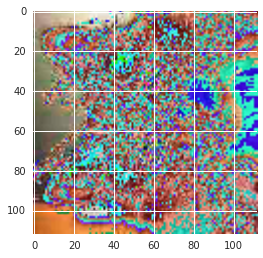

I am 96.42% sure this is a Dog


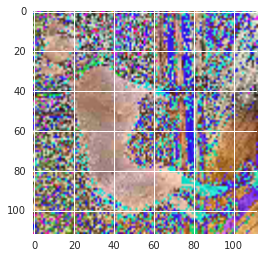

I am 96.88% sure this is a Dog


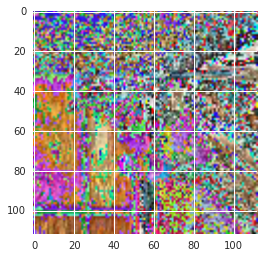

I am 98.32% sure this is a Cat


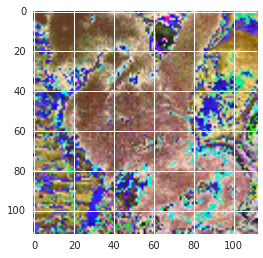

I am 99.98% sure this is a Dog


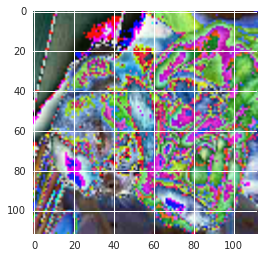

I am 100.00% sure this is a Dog


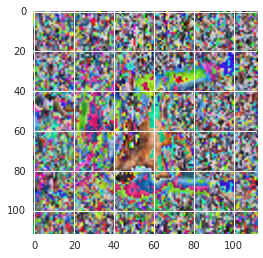

I am 99.87% sure this is a Dog


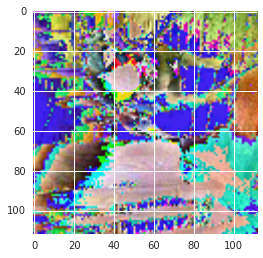

I am 100.00% sure this is a Cat


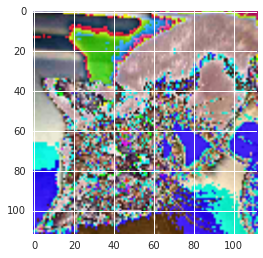

I am 75.72% sure this is a Dog


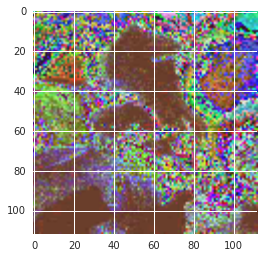

I am 99.64% sure this is a Dog


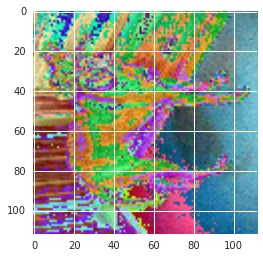

I am 100.00% sure this is a Dog


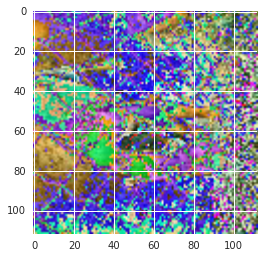

I am 76.68% sure this is a Cat


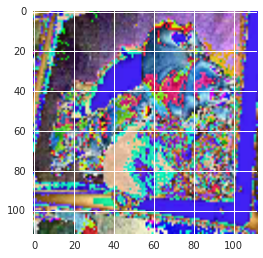

I am 94.97% sure this is a Dog


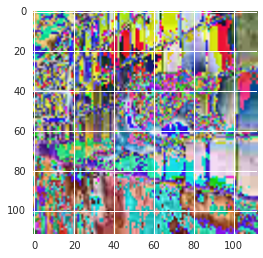

I am 100.00% sure this is a Dog


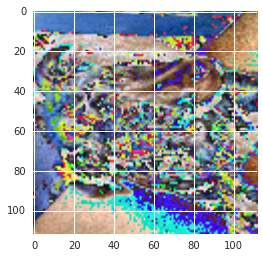

I am 99.99% sure this is a Cat


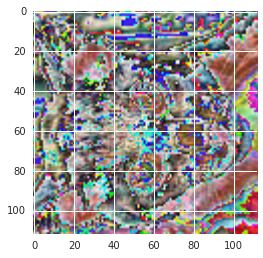

I am 81.84% sure this is a Cat


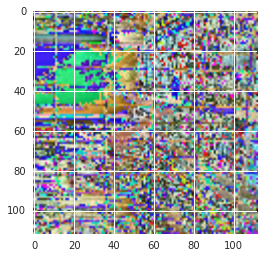

I am 99.99% sure this is a Cat


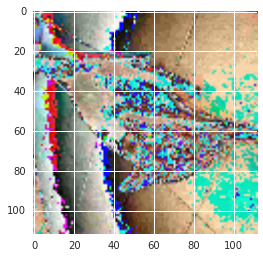

I am 98.02% sure this is a Dog


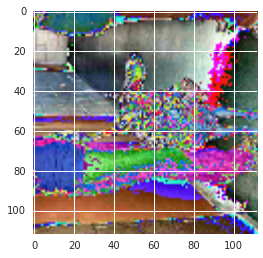

I am 100.00% sure this is a Dog


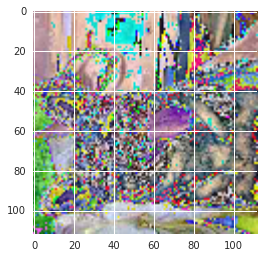

I am 99.98% sure this is a Cat


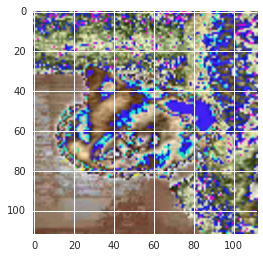

I am 99.99% sure this is a Cat


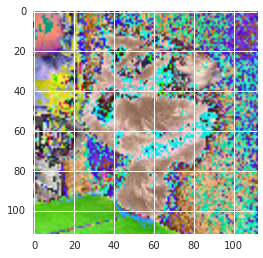

I am 99.05% sure this is a Dog


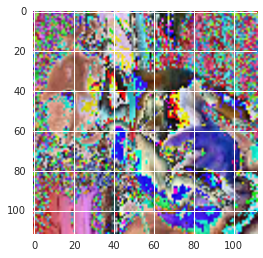

I am 99.96% sure this is a Cat


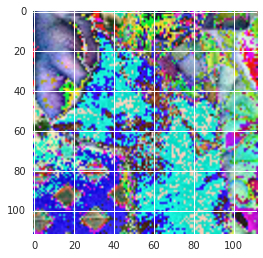

I am 100.00% sure this is a Cat


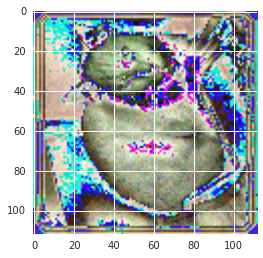

I am 100.00% sure this is a Cat


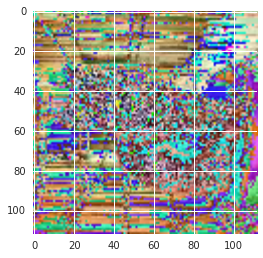

I am 99.28% sure this is a Dog


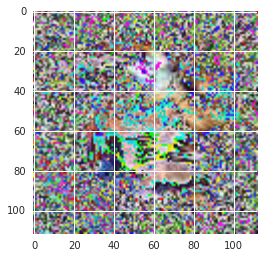

I am 99.99% sure this is a Dog


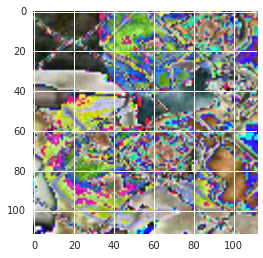

I am 95.10% sure this is a Dog


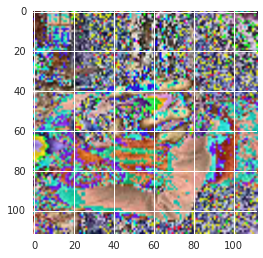

I am 100.00% sure this is a Dog


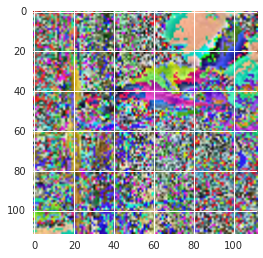

I am 99.99% sure this is a Dog


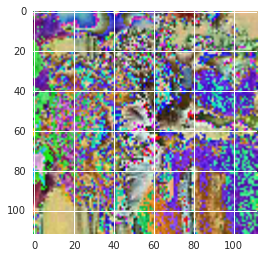

I am 100.00% sure this is a Cat


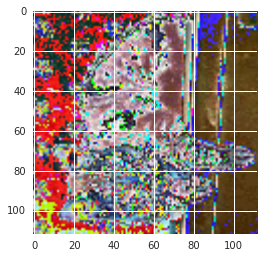

I am 99.99% sure this is a Cat


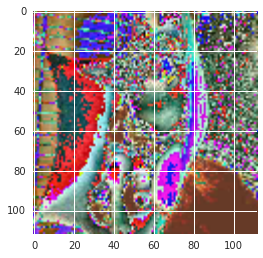

I am 98.73% sure this is a Cat


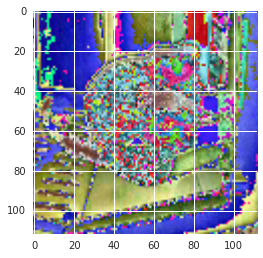

I am 100.00% sure this is a Dog


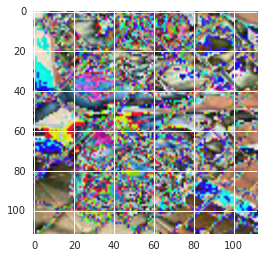

I am 100.00% sure this is a Cat


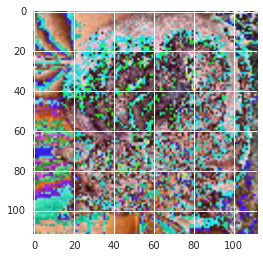

I am 98.31% sure this is a Dog


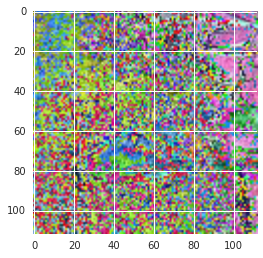

I am 100.00% sure this is a Cat


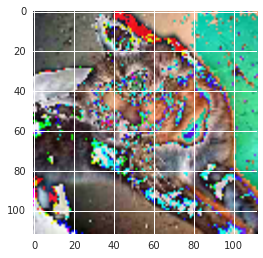

I am 100.00% sure this is a Dog


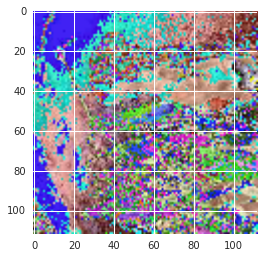

I am 97.24% sure this is a Dog


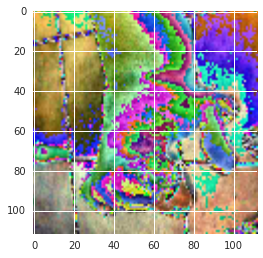

I am 86.16% sure this is a Cat


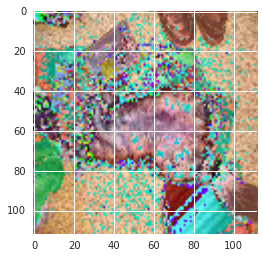

I am 100.00% sure this is a Dog


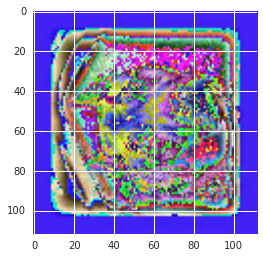

I am 100.00% sure this is a Cat


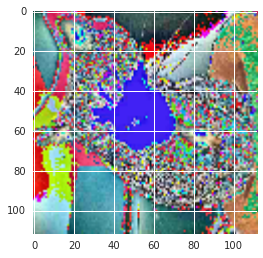

I am 99.96% sure this is a Cat


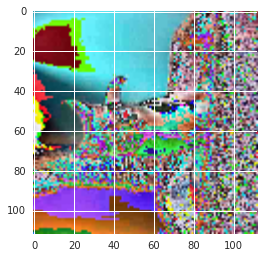

I am 100.00% sure this is a Dog


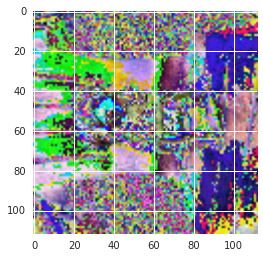

I am 99.91% sure this is a Dog


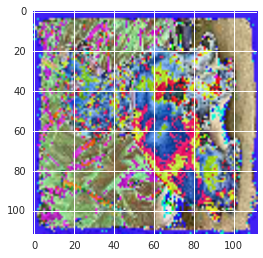

I am 100.00% sure this is a Dog


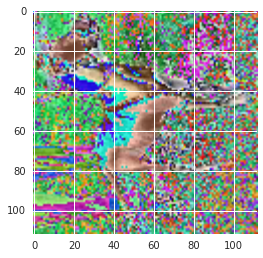

I am 100.00% sure this is a Cat


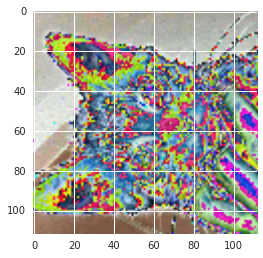

I am 87.45% sure this is a Dog


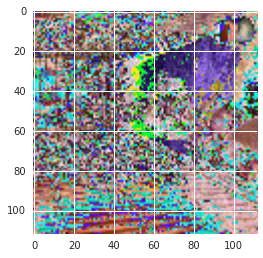

I am 98.06% sure this is a Dog


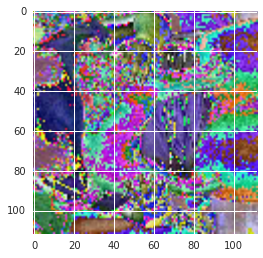

I am 98.88% sure this is a Dog


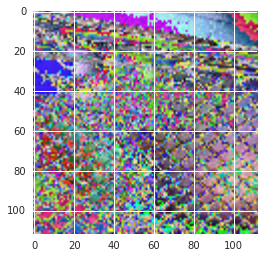

In [34]:
for i in range(0,50):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()